In [47]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# If you are working in Colab, then consider mounting folder to your drive
from google.colab import drive
drive.mount('/content/drive')

# Direct to your folder.
%cd /content/drive/MyDrive/computer_vision/diffusion_models/

Mounted at /content/drive
/content/drive/MyDrive/computer_vision/diffusion_models


In [48]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel three times
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize all three channels
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

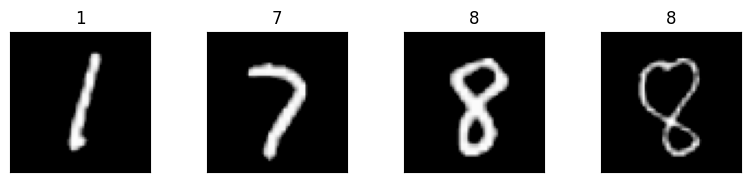

In [51]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

images = np.transpose(images, (0, 2, 3, 1))
images = np.clip(images, 0, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx])
    ax.set_title(str(labels[idx].item()))

plt.show()

In [52]:
from ddpm import Diffusion, Trainer, UNet
import torch

img_size = next(iter(trainloader))[0].shape[-1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet(in_channels=3, out_channels=3, timestep_dim=32, device=device)
diffusion = Diffusion(noise_steps=1000, schedule_type='cosine', img_size=img_size, device=device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

trainer = Trainer(model=unet,
                  diffusion=diffusion,
                  optimizer=optimizer,
                  criterion=criterion,
                  trainloader=trainloader,
                  save_path='mnist_ddpm.pth',
                  device=device)

Epoch 1/3 - Loss: 0.0190: 100%|██████████| 15000/15000 [12:23<00:00, 20.18it/s]
Generating images: 16it [00:00, 1906.34it/s]


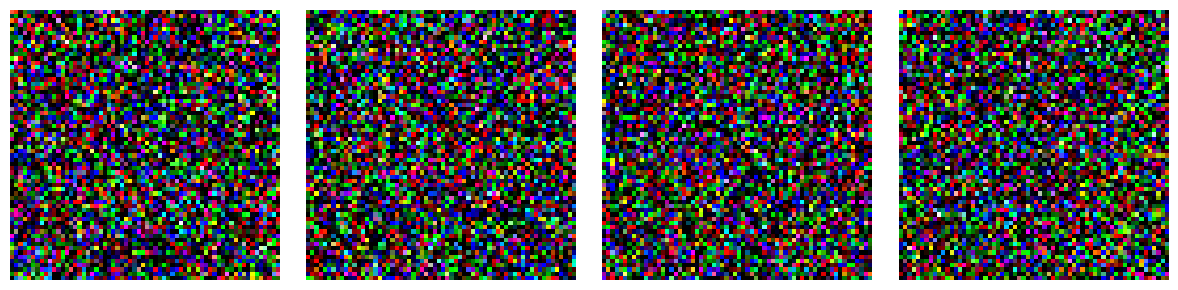

Epoch 2/3 - Loss: 0.0109: 100%|██████████| 15000/15000 [12:23<00:00, 20.16it/s]
Generating images: 16it [00:00, 2033.11it/s]


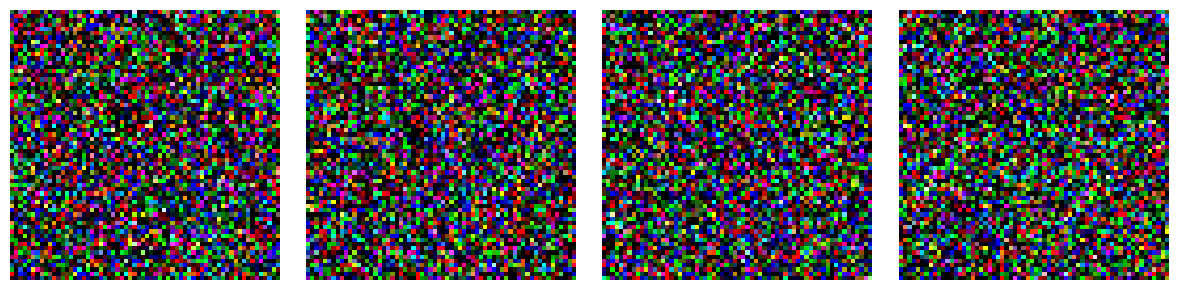

Epoch 3/3 - Loss: 0.0111: 100%|██████████| 15000/15000 [12:26<00:00, 20.10it/s]
Generating images: 16it [00:00, 1879.01it/s]


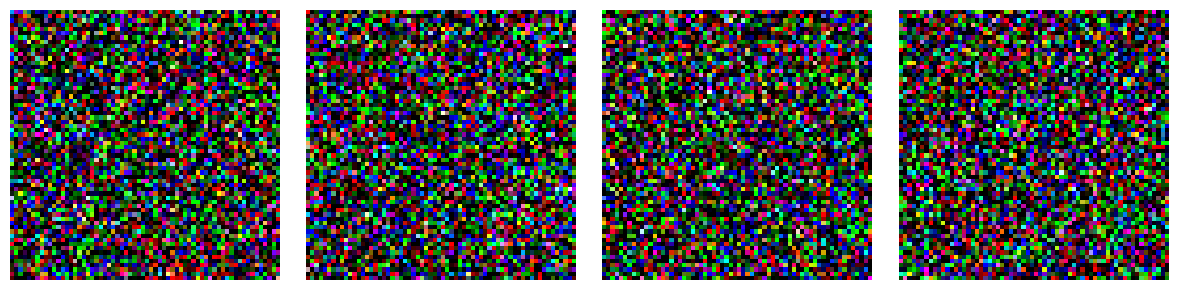

Training complete


In [24]:
trainer.train_model(epochs=3)

In [ ]:
# load the model
trained_unet = UNet(in_channels=3, out_channels=3, timestep_dim=2)
trained_unet.load_state_dict(torch.load('models/mnist_ddpm.pth', map_location=torch.device('cpu')))

# test the model
generated_images = diffusion.generate_images(trained_unet)

fig, axs = plt.subplots(1, 4, figsize=(4 * 3, 3))
for i, ax in enumerate(axs.flat):
    img = generated_images[i].cpu().permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sampled timesteps: tensor([133,  15, 764, 719])


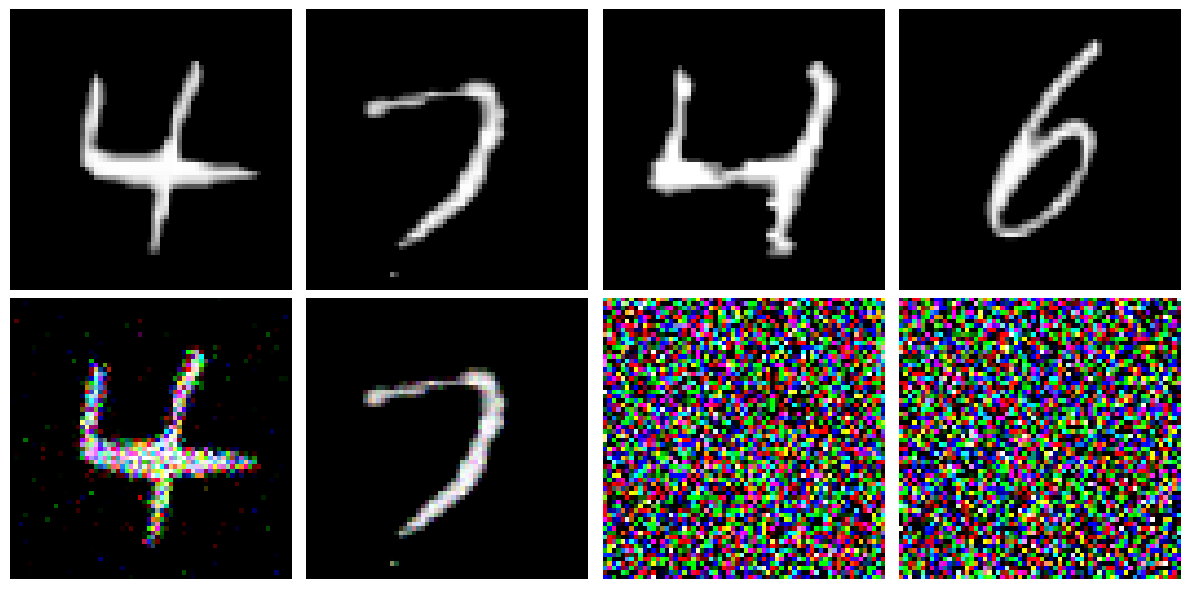

In [38]:
diffusion_linear = Diffusion(noise_steps=1000, img_size=next(iter(trainloader))[0].shape[-1], schedule_type='linear', device=device)

# Fetch images and apply noise
images, _ = next(iter(testloader))
timesteps = diffusion_linear.sample_timesteps(images.shape[0])
print(f"Sampled timesteps: {timesteps}")
noised_images, _ = diffusion_linear.noise_images(images, timesteps)

n_images = images.size(0)

# Create figure with subplots
fig, axs = plt.subplots(2, n_images, figsize=(12, 6))  # Adjust figsize for better layout

# Plot original images in the first row
for i in range(n_images):
    img = images[i].permute(1, 2, 0).detach().cpu().numpy()
    axs[0, i].imshow(img)
    axs[0, i].axis('off')

# Plot noised images in the second row
for i in range(n_images):
    img = noised_images[i].permute(1, 2, 0).detach().cpu().numpy()
    axs[1, i].imshow(img)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

Sampled timesteps: tensor([709,  15,   7, 669])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


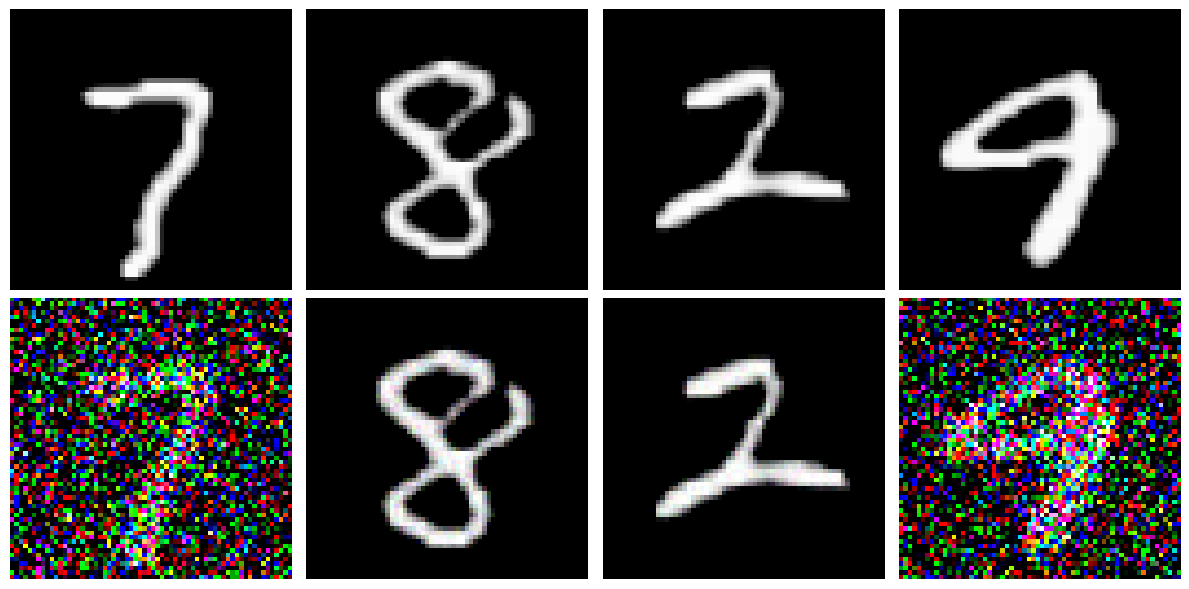

In [41]:
diffusion_cosine = Diffusion(noise_steps=1000, img_size=next(iter(trainloader))[0].shape[-1], schedule_type='cosine', device=device)

# Fetch images and apply noise
images, _ = next(iter(testloader))
timesteps = diffusion_cosine.sample_timesteps(images.shape[0])
print(f"Sampled timesteps: {timesteps}")
noised_images, _ = diffusion_cosine.noise_images(images, timesteps)

n_images = images.size(0)

# Create figure with subplots
fig, axs = plt.subplots(2, n_images, figsize=(12, 6))  # Adjust figsize for better layout

# Plot original images in the first row
for i in range(n_images):
    img = images[i].permute(1, 2, 0).detach().cpu().numpy()
    axs[0, i].imshow(img)
    axs[0, i].axis('off')

# Plot noised images in the second row
for i in range(n_images):
    img = noised_images[i].permute(1, 2, 0).detach().cpu().numpy()
    axs[1, i].imshow(img)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()